## <b> KNN Notebook </b>

### <b> Goals </b>

The goals of our project are focused around implementing ways to improve the way the KNN algorithm classifies binary data when consuming datasets that present heavy class imbalances.

### <b> KNN base algorithm </b>

This is the base algorithm along with its classifier and regressor.

In [1]:
from collections import Counter
import numpy as np
from scipy.spatial.distance import euclidean
from base import BaseEstimator


class KNNBase(BaseEstimator):
    def __init__(self, k=5, distance_func=euclidean):
        self.k = k
        self.distance_func = distance_func

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)

    def _predict_x(self, x):
        distances = [self.distance_func(x, example) for example in self.X]
        neighbors = sorted(zip(distances, self.y), key=lambda x: x[0])
        neighbors_targets = [target for (_, target) in neighbors[:self.k]]
        return self.aggregate(neighbors_targets)

    def get_params(self, deep=True):
        return {'k': self.k, 'distance_func': self.distance_func}

    def set_params(self, **params):
        if 'k' in params:
            self.k = params['k']
        if 'distance_func' in params:
            self.distance_func = params['distance_func']


class KNNClassifier(KNNBase):
    def aggregate(self, neighbors_targets):
        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label


class KNNRegressor(KNNBase):
    def aggregate(self, neighbors_targets):
        return np.mean(neighbors_targets)


### <b> Dataset Exploratory Data Analysis </b>

In this section of the notebook our aim is to better understand our dataset.
As previously mentioned our main focus is to tackle KNN problems related to Binary Class Imbalances, therefore we'll start by checking if the datasets we'll be using actually do present those problems.

In [2]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml #Fetch Method for OpenML datasets

##### <b> Functions to extract data and observe binary class imbalances </b>



In [3]:
#Function to fetch datasets and transform them into dataframe
def dataset_fetcher(dataset_id):
    #Fetch OpenML dataset
    dataset = fetch_openml(data_id=dataset_id, version='active', as_frame=True)
    
    dataset_name = dataset.details['name']

    #Convert dataset to pandas dataframe
    df = dataset.frame

    #Change last column name to "class" in all dataframes
    last_column_name = df.columns[-1] 
    df = df.rename(columns={last_column_name: 'class'})


    return df, dataset_name


#Function to show number of entries for each label/class
def item_number_per_class(dataframe, ds_name):

    #Select class column
    label_column = dataframe.iloc[:,-1]
    
    # Count the occurrences of each value
    occurrences = label_column.value_counts()

    return occurrences, ds_name

#Function to plot the data
def plot_number_of_entries_per_class(num_occurrences, dsname):

    
    plt.figure(figsize=(3, 2))

    # Plotting the occurrences as a bar chart
    num_occurrences.plot(kind='bar', rot=0)

    # Adding labels and title
    plt.xlabel('Item')
    plt.ylabel('Count')
    plt.title(f'Occurrences of Each Item in {dsname}')

    # Display the plot
    plt.show()

#Pipline for EDA
def data_generation_pipeline(datasets_id):

    '''
    Function will return a list of dataframes that will then be used to benchmark the algorithm
    '''
    dataframes = []
    for id in datasets_id:
        dataframe, dsname = dataset_fetcher(id)
        dataframes.append(dataframe)
        occurrences, dsname = item_number_per_class(dataframe, dsname)
        plot_number_of_entries_per_class(occurrences, dsname)

    return dataframes
    
    

/home/rodribro/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


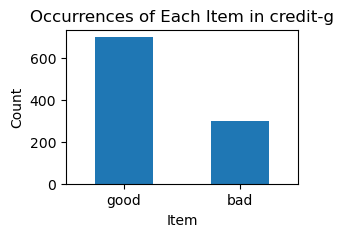

/home/rodribro/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


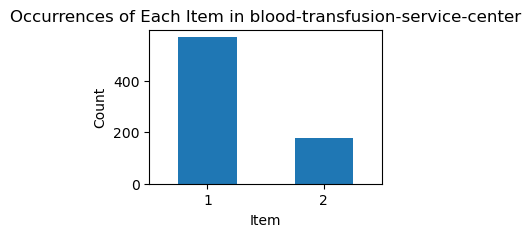

/home/rodribro/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


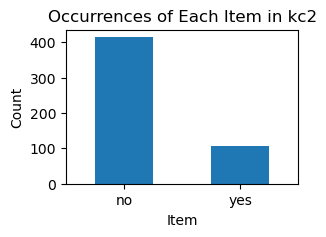

/home/rodribro/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


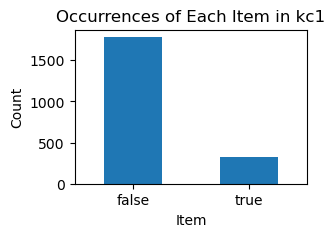

/home/rodribro/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


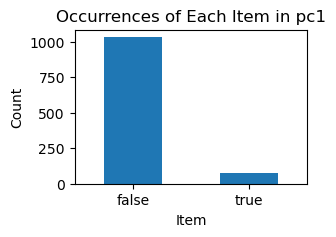

In [4]:
dataset_id_list = [31, 1464, 1063, 1067, 1068]
dataframes = data_generation_pipeline(dataset_id_list)



As displayed above in the graphs, we can clearly see that every single one of the datasets that we are using has severe class imbalances.

#### <b> Convert non-numeric values to numeric values </b>

Since our Classifier only works with numerical values, we need to replace all of the non-numerical entries in our dataframe.
We also want to ensure that in each column, the identity of the unique data points is preserved, meaning that within the same column previously non-numerical values that are the same will also have the same numerical representation.

On top of that, we'll also implement a way to replace non-available values (NaN) by inserting the mean of the column by NaN in a given entry.

In [110]:
from sklearn.preprocessing import LabelEncoder
def encode_non_numerical_and_nan(df):
    df_encoded = df.copy()
    
    for column in df_encoded.columns:
        if pd.api.types.is_object_dtype(df_encoded[column]) or df_encoded[column].apply(lambda x: isinstance(x, str)).any():
            le = LabelEncoder()
            df_encoded[column] = le.fit_transform(df_encoded[column])

    # Replace NaN values with the mean of the column
    for column in df_encoded.columns:
        if df_encoded[column].isnull().any():
            mean_value = df_encoded[column].mean()
            df_encoded[column].fillna(mean_value, inplace=True)
    
    return df_encoded

In [113]:

df1 = dataset_fetcher(40918)[0]

#df1.head()

df1_encoded = encode_non_numerical(df1)

df1_encoded.tail()


/home/rodribro/anaconda3/envs/machinelearning/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/tmp/ipykernel_123595/36762688.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the o

,dt,AverageTemperature,AverageTemperatureUncertainty,class
577457,3234,19.059000,1.022000,241
577458,3235,17.613000,0.473000,241
577459,3236,17.000000,0.453000,241
577460,3237,19.759000,0.717000,241
577461,3238,17.193354,1.019057,241


### <b> Performance of the base KNN Algorithm </b>

Now, we'll benchmark the base implementation of the KNN algorithm, using some well defined metrics, to see how it performs when we feed it the previously chosen datasets.

In [5]:
#Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import KFold

In [6]:

def knnPerformanceMetrics(dataframe_set, test_size=0.2, random_state=42):
    
    # Separate features from class labels
    X = dataframe_set.drop(columns=['class'])  # Features
    y = dataframe_set['class']  # Labels

    #Instantiation of a classifier
    knn=KNNClassifier(5)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    

    return accuracy

In [8]:
#Precision, Recall, F1, AUC - ROC

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def knnPerformanceMetrics(dataframe_set, n_splits=5, random_state=42):

    # Determine majority and minority classes
    class_counts = dataframe_set['class'].value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()

    # Map class values to 0 and 1 based on majority and minority classes
    dataframe_set['class'] = dataframe_set['class'].map({majority_class: 0, minority_class: 1})

    
    # Separate features from class labels
    X = dataframe_set.drop(columns=['class'])  # Features
    y = dataframe_set['class']  # Labels

    # Instantiate a classifier
    knn = KNNClassifier(7)

    # Define the k-fold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize lists to store metric scores
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        knn.fit(X_train, y_train)

        # Make predictions
        y_pred = knn.predict(X_test)

        # Calculate evaluation metrics
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

        # For AUC-ROC, we need probability scores instead of class labels
        '''
        y_prob = knn.predict_proba(X_test)[:, 1]  # Probability of being in class 1
        auc_roc_scores.append(roc_auc_score(y_test, y_prob))
        '''

    # Calculate mean scores
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    #mean_auc_roc = np.mean(auc_roc_scores)

    return mean_accuracy, mean_precision, mean_recall, mean_f1 #, mean_auc_roc]


In [10]:
# Example usage:
mean_accuracy, mean_precision, mean_recall, mean_f1 = knnPerformanceMetrics(dataframerinos, n_splits=5)
print(f"Mean Accuracy: {mean_accuracy}, Mean Precision: {mean_precision}, Mean Recall: {mean_recall}, Mean F1 Score: {mean_f1}")

Mean Accuracy: 0.9278586278586278, Mean Precision: 0.52, Mean Recall: 0.10033834586466166, Mean F1 Score: 0.1654970760233918


In [11]:
#k=3 [0.7647695749440716, 0.5222943722943724, 0.2958265723509626, 0.3714872838346756]
#k=5 [0.7674541387024609, 0.5229840906614361, 0.3220219985463888, 0.39343201557352503]
#k=7 [0.7647695749440716, 0.5222943722943724, 0.2958265723509626, 0.3714872838346756]